In [2]:
### UTILITIES - MUST RUN THIS CELL

import numpy as np
import random
import matplotlib.pyplot as plt

# Steps along which the walk can step
STEPS = set([(1, 0), (0, 1), (-1, 0), (0, -1)])

# Colours for plots
RED = (1.00, 0.28, 0.18)
GREEN = (0.15, 0.64, 0.23)
GOLD = (1.00, 0.65, 0.06)
BLUE = (0.32, 0.57, 0.83)

def CartesianToLetter(Path: list[tuple]) -> str:
    ''' Convert a walk from Cartesian Coordinates to a more readable format (U,D,L,R) '''
    conversion = {(0,1):'U', (0,-1):'D', (-1,0):'L', (1,0):'R'}
    return "".join([conversion[(Path[i+1][0]-Path[i][0],Path[i+1][1]-Path[i][1])] for i in range(len(Path)-1)])

# Returns the coordinates of the neighbour to site given a direction to move 
GetNeighbour = lambda site, direction: tuple(x+y for x,y in zip(site, direction))


Configuration:
# of Steps: 200
# of Spikes: 61
Spike locations: [1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0]


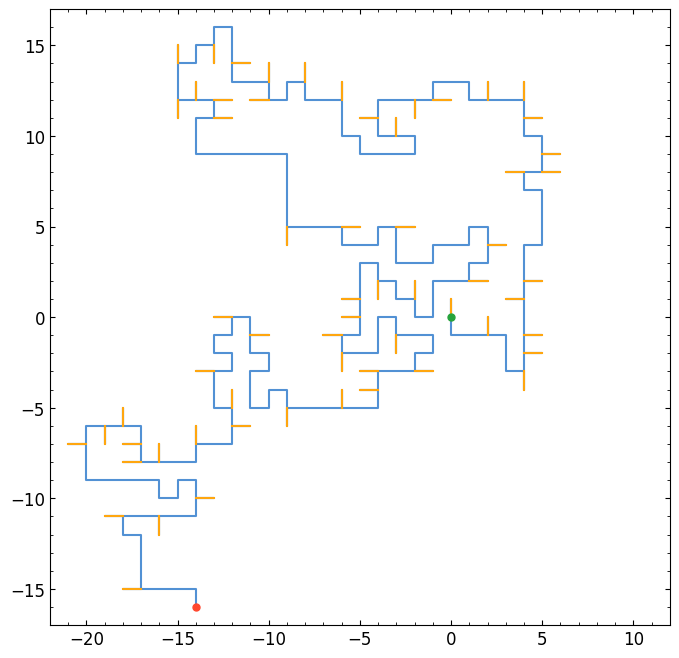

In [3]:
### SINGLE SPIKE PER VERTEX SAW (CACTUS WALK)

# Example of a single cactus walk
MAX_SIZE = 200

plt.figure(figsize=(8,8))

# Retry until a walk of length max_size has been found
n = 0
while n != MAX_SIZE:
    site = (0,0)
    Path = [site]
    last_spike = []
    spike_loc = np.zeros(MAX_SIZE+1, dtype=int)
    # s_plots[] not required: only used to highlight spikes
    s_plots = []
    n = m = 0
    a = 1
    while n < MAX_SIZE:
        if a == 0: 
            # Terminate the walk early when there is no where else to grow to
            break
        # Get neighbouring sites and enforce self avoidance
        neighbours = [GetNeighbour(site,step) for step in STEPS]
        valid_neighbours = [site for site in neighbours if site not in Path[:-2] if site not in last_spike]
        # Determine the atmosphere, a
        a = len(valid_neighbours)
        if a:
            # Step at random to one of the unvisited neighbours
            site = random.choice(valid_neighbours)
            Path.append(site)
            n += 1
            # Prevent index being out of bounds
            if n > 1:
                # Determine whether a spike has formed
                if site == Path[-3]:
                    # Account for the 2 steps taken to form the spike
                    n -= 2
                    m += 1
                    # Highlight spikes
                    last_spike = Path[-3:-1]
                    spike_loc[n] += 1
                    s_plots.append(last_spike)
    
print('\nConfiguration:')
print(f'# of Steps: {n}')
print(f'# of Spikes: {m}')
print(f'Spike locations: {spike_loc[:n+1]}')

# Plot the walk (includes spikes)
x = [v[0] for v in Path]
y = [v[1] for v in Path]
plt.plot(x,y, color=BLUE)

# Plot spikes on top
for spike in s_plots:
    plt.plot([spike[0][0], spike[1][0]], [spike[0][1], spike[1][1]], color=GOLD)

# Plot start and end points
plt.plot(0, 0, 'o', color=GREEN, markersize=5)
plt.plot(Path[-1][0], Path[-1][1], 'o', color=RED, markersize=5)

# Plot customization
# Create a bounding box to surround the walk adjusted to include some padding
pad = 1
# Get length of the longest axis spanned by the walk
dist_x = max(x)-min(x)
dist_y = max(y)-min(y)
longest_axis = max(dist_x, dist_y)
plt.axis([min(x)-pad, min(x)+longest_axis+pad, min(y)-pad, min(y)+longest_axis+pad])

plt.minorticks_on()
plt.tick_params(direction='in',which='both',left=True,right=True,bottom=True,top=True,labelsize=12)

plt.show()

In [4]:
### EXACT ENUMERATION FOR SINGLE SPIKE PER VERTEX

# Counts need to be reset each run
counts = {}

def GenerateCactus(steps_left: int, n: int = 0, m: int = 0, Path: list[tuple] = [(0, 0)], Spikes: list = []) -> None:
    '''
    Generate cactus walks with n steps in path, forming some spikes
    each spike is a leaf of the graph given by the two associated points, only save tip of the spike
    the path includes the spikes, but when spikes get formed they also get added to a separate list
    
    NOTE 1: This suppresses "embedded" spikes such as UDU
    
    NOTE 2: This version does not allow, for example, UDLR, as the last step would count as an overlap with the origin;
            for simplicity, I suggest we can leave it as is
            
    NOTE 3: Only last generated spike is really needed, there is some minor overhead 
    '''
    # Count configurations
    if (n,m) in counts:
        counts[(n,m)] += 1
    else:
        counts[(n,m)] = 1

    if steps_left == 0:
        # Path of maximal length has been explored, end recursion
        True
    else:
        # Compute all the neighbours of the current site
        neighbours = [GetNeighbour(Path[-1], step) for step in STEPS]
        # Filter for points not on the Path and points not on Spikes, but allowing for an immediate reversal
        valid_neighbours = [site for site in neighbours if site not in Path[:-2] if site not in Spikes]

        if len(valid_neighbours) > 0:
            # Create all possible continuations
            for new_site in valid_neighbours:
                # Each continuation will have its own length, energy etc.
                local_n = n
                local_m = m
                local_SL = steps_left
                if new_site not in Path:
                    # Continue by taking a step
                    GenerateCactus(local_SL-1, local_n+1, local_m, Path+[new_site], Spikes)
                else:
                    # A spike has formed, add tip to Spikes and adjust the length of the spine, local_n, accordingly
                    GenerateCactus(local_SL+1, local_n-1, local_m+1, Path+[new_site],Spikes+[Path[-1]])

N = 5
# Since a square lattice is rotationally symmetrical, we can always start by taking the first
# step in just one direction and then adjust the counts by multiplying by 4
GenerateCactus(N+1, n=1, m=0, Path=[(0,0),(1,0)])

# Record data collected in 'cactus_saw_counts.ser' file, but only if new data has been collected
with open('cactus_saw_counts.ser','r') as f_r:
    longest_config = 0
    text = f_r.readlines()
    if text:
        # Get the length of the longest walks that were last recorded
        longest_config = int(text[-1].split()[0])
    if longest_config < N or not text:
        # New data for longer walks has been collected, append it to 'cactus_saw_counts.ser'
        with open('cactus_saw_counts.ser','a') as f_a:
            for n,m in sorted(counts):
                if n > longest_config and n < N+1:
                    # Only append NEW data
                    f_a.write(" ".join(map(str,[n,m,4*counts[n,m]])))
                    f_a.write("\n")
    else:
        # No new data has been collected, ignore
        pass

print("0 0 1")
for n,m in sorted(counts):
    if n < N+1:
        print(n,m,4*counts[n,m])

0 0 1
0 1 4
1 0 4
1 1 24
1 2 36
2 0 12
2 1 96
2 2 244
2 3 200
3 0 36
3 1 344
3 2 1196
3 3 1776
3 4 952
4 0 100
4 1 1136
4 2 4972
4 3 10472
4 4 10576
4 5 4096
5 0 284
5 1 3672
5 2 19236
5 3 52000
5 4 76216
5 5 57232
5 6 17192


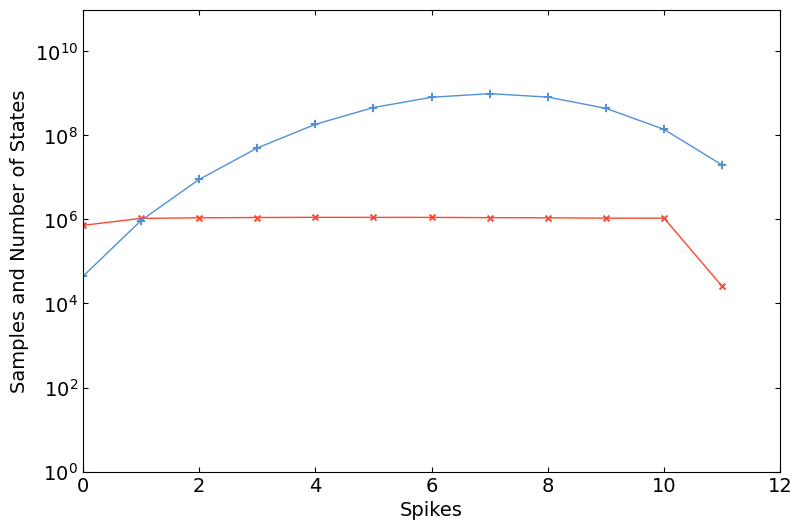

In [13]:
def flatperm_cactus_saw(max_size,max_tours):
    
    '''
    Produce a roughly uniform distribution of a two-dimensional self-avoiding walk based on
    the total size and number of tours of the walk using the Pruned and Enrichment Rosenbluth Method.
    
    Samples and weights are separated based on both length of the spine, in steps, and number of spikes;
    spikes occur when the next step of the walk is an immediate reversal e.g. R(UD), where R U D are steps
    right up and down respectively - the spike is highlighted with ()
   
    Parameters
    ----------
    max_size: maximum size, referring to the spine, of the walk
    max_tours: total number of tours
    
    Returns
    -------    
    Two lists s,w where each entry s[n,m] represents the number of n-step walks explored with precisely
    m sapikes, from n,m = 0 to n,m = max_size + 1 and each entry w[n,m] being the corresponding
    weights
    '''
    
    max_steps = 3*max_size + 2
    
    s = np.zeros((max_size+1, max_size+1))
    w = np.zeros((max_size+1, max_size+1))
    copy = np.zeros(max_steps)
    weight = np.zeros(max_steps)
    
    # Tells us at precisely what step a spike occurs so when retracing steps
    # we know when to deal with spikes
    spike_loc = np.zeros(max_size+1, dtype=int)
    
    # Spine tracks the length of the cactus walk excluding the spikes
    tours = spine = m = N = 0
    # Start new walk at origin and step size zero
    a = copy[0] = weight[0] = 1
    s[0,0] += 1; w[0,0] += weight[0]
    site = (0,0)
    occupied_sites = [site]
    spikes = []
    while tours < max_tours:
        # If maximal length has been reached or the atmosphere is zero: Don't grow
        if spine == max_size or a == 0:
            copy[N] = 0
        else:
            # Pruning/enrichment by comparing the target weight with the averaged weight estimate
            ratio = weight[N] / (w[spine,m] / s[0,0])
            p, r = ratio % 1, random.random()
            # Generate a random number between 0 and 1
            if r < p:
                copy[N] = np.floor(ratio) + 1
            else:
                copy[N] = np.floor(ratio)
            weight[N] = w[spine,m] / s[0,0]
        if copy[N] == 0:
            while N > 0 and copy[N] == 0:
                if spike_loc[spine]:
                    # Site has spike, remove the spike and adjust the spine accordingly
                    m -= 1
                    spike_loc[spine] -= 1
                    spine += 2
                    spikes = spikes[:-2]
                    
                # Delete last site of walk
                occupied_sites = occupied_sites[:-1] 
                site = occupied_sites[-1]
                spine -= 1
                N -= 1
                
        if N == 0 and copy[0] == 0:
            # Start new tour
            tours += 1
            # Start new walk with step size zero
            a, copy[0] = 1, 1
            s[0,0] += 1; w[0,0] += weight[0]
            site = (0,0)
            occupied_sites = [site]
        else:
            # Create list of neighboring unoccupied sites, determine the atmosphere a
            next_points = [GetNeighbour(occupied_sites[-1],step) for step in STEPS]
            # Filter for points not on the Path and points not on Spikes, but allowing for an immediate reversal
            unoccupied_sites = [site for site in next_points if site not in occupied_sites[:-2] if site not in spikes]
            a = len(unoccupied_sites)
            # If the walk cannot continue, reject entire walk and exit loop
            if a > 0:
                copy[N] -= 1
                # Draw one of the neighbouring unoccupied sites uniformly at random
                # Step to new site
                site = random.choice(unoccupied_sites)
                occupied_sites.append(site)
                spine += 1  
                N += 1
                # Prevent index being out of bound for occupied_sites
                if spine > 1:
                    if site == occupied_sites[-3]:
                        # Spike has formed, add to list of spikes and adjust the spine accordingly
                        spikes += occupied_sites[-3:-1]
                        m += 1
                        spine -= 2
                        spike_loc[spine] += 1
                weight[N] = weight[N-1]*a
                s[spine,m] += 1; w[spine,m] += weight[N]
    s[0,0] -= 1; w[0,0] -= 1
    
    return s,w/s[0,0]

# Example
max_size, max_tours = 10, 1e6
s,w = flatperm_cactus_saw(max_size+2,max_tours)
plt.figure(figsize=(9,6))

# Extract the samples that generated max length walks with m = [0,max_size+1] spikes
# array[array != 0] discards the zero entries
max_size_samples = s[max_size,]
plt.plot(max_size_samples[max_size_samples != 0], 'x-', color=RED, lw=1, ms=1, mew=6)

# Estimate number of configurations
estimated_counts = w[max_size,]-----------------
estimated_counts = estimated_counts[estimated_counts != 0]
plt.plot(estimated_counts, '+-', color=BLUE, lw=1, ms=1, mew=6)

# Plot customization
plt.yscale('log')
plt.xlabel('Spikes',fontsize=14)
plt.ylabel('Samples and Number of States',fontsize=14)
plt.axis([0,max_size + 2, 1, max(estimated_counts) * 100])
plt.tick_params(direction='in',left=True,right=True,bottom=True,top=True,labelsize=14)
plt.show()

In [14]:
cactus_saw_data = np.zeros(max_size+2)
with open('cactus_saw_counts.ser', 'r') as f:
    f_content = [line.split() for line in f.readlines()]
    max_size_configs = []
    # Extrapolate all lines enumerating max_size step configurations
    max_size_configs = [line for line in f_content if int(line[0]) == max_size]
    # Clean up remaining lines by casting to ints 
    max_size_configs = [list(map(lambda x: int(x), line)) for line in max_size_configs] 
    # Assign the data given the extrapolated counts
    for line in max_size_configs:
        cactus_saw_data[line[1]] = line[2]

# Convert ratio to percentage and return as str (format to 2dp include trailing zeros)
ToPercent = lambda ratio : f'{(abs(1 - ratio) * 100):.2f}%'
ratios = estimated_counts/cactus_saw_data

# Output the variance between the estimated counts and the exact counts
print(f'{max_size} Step Configurations')
print('\nVariance as ratios')
print(ratios)

print('\nVariance as percentages')
percentages = np.array(list(map(ToPercent, ratios)))
line_length = 10
for x in range(0,len(percentages), line_length):
    print(', '.join(percentages[x:x+line_length]))

10 Step Configurations

Variance as ratios
[0.99998814 0.99991514 0.99991247 1.00004358 1.00264207 1.00383593
 1.00824918 1.00820513 1.00111482 0.99752461 0.99429826 1.00413115]

Variance as percentages
0.00%, 0.01%, 0.01%, 0.00%, 0.26%, 0.38%, 0.82%, 0.82%, 0.11%, 0.25%
0.57%, 0.41%
